# Individual Final Project: Models of Prediction
---
### Student ID: GH1024311
### Christian Jensen
#### [URL](https://www.kaggle.com/datasets/duttadebadri/identifying-different-breeds-of-snakes) of the Dataset used for this project
---

# Problem Statement

Elaborate the task.
- What is the underlying problem and why is it important?
- How solving the problem will benefit the company?
- How would you collect relevant data?
- How would you formulate this problem as a machine learning task?

---
---
---
# Data Exploration and Characteristics

---
## Step O: Import Usefule Packages and Image Dataset

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import os
import random
import matplotlib.cm as cm
import cv2
import seaborn as sns

In [2]:
# Load the Drive from where we have the folders
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls /content/drive/My\Drive/Snakes

agkistrodon  haldea	   masticophis	opheodrys     rhinocheilus
crotalus     heterodon	   natrix	pantherophis  storeria
diadophis    lampropeltis  nerodia	pituophis     thamnophis


In [4]:
dataset_path = "/content/drive/MyDrive/Snakes"

---
---
## Step 1: Placing the images and labels into a dataframe

In [5]:
image_dir = Path(dataset_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
# Randomly pick 1500 images with their corresponding labels
image_df = image_df.sample(n=1500, random_state=24).reset_index(drop=True)

---
---
## Step 2: Create the function to resize all images in the dataframe

In [11]:
Batch_size = 36 # Square root of the training_set size
Target_size = (224, 224)  # Resize images to the specified size

In [23]:
from PIL import Image

# Function to load and resize images
def load_image(filepath, size):
    img = Image.open(filepath)
    img = img.resize(size)  # Resize image to target size
    return np.array(img)


images = np.array([load_image(filepath, Target_size) for filepath in image_df['Filepath']])


---
---
## Step 3: Display the images with their corresponding species label


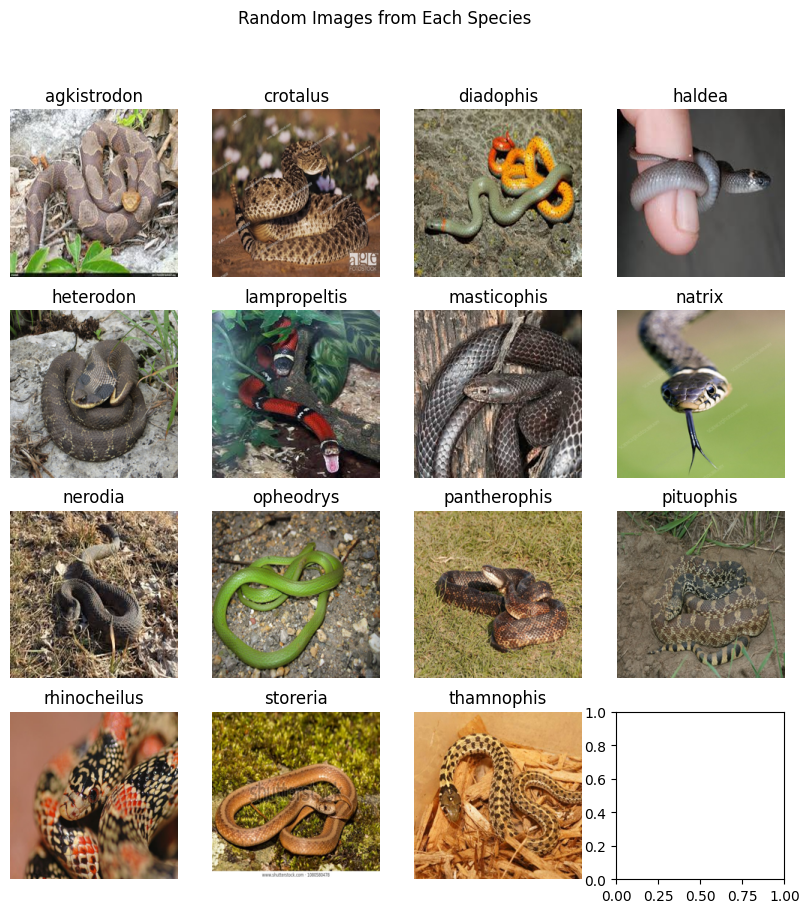

In [25]:
labels, counts = np.unique(image_df['Label'], return_counts=True)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, label in enumerate(labels):
  ax = axes[i // 4, i % 4]
  random_index = random.randint(0, counts[i] - 1)
  image_index = np.where(image_df['Label'] == label)[0][random_index]
  ax.imshow(images[image_index])
  ax.set_title(label)
  ax.axis('off')

plt.suptitle('Random Images from Each Species')
plt.show()


---
---
## Step 4: Data Preprocessing

In [26]:
# The X consist of the images of the snakes
train_df, test_df, X_train, X_test = train_test_split(
    image_df, images, test_size=0.2, shuffle=True, random_state=24
    )

In [27]:
# The Y are all the labels from the snakes species
Y_train, Y_test = train_df.Label, test_df.Label

In [28]:
# Scale these values to a range of 0 to 1 previews to working the models.
X_train = X_train / 255.0

X_test = X_test / 255.0

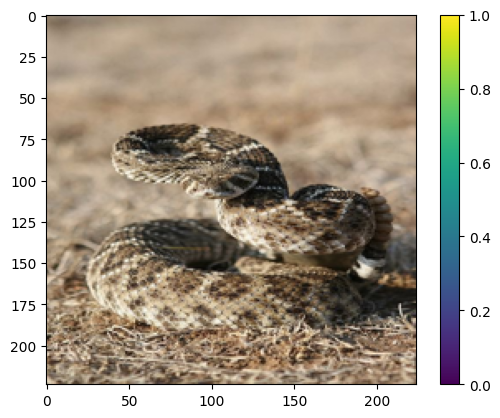

In [29]:
plt.figure()
plt.imshow(X_train[33])
plt.colorbar()
plt.grid(False)
plt.show()

---
---
## Step 5: Using Label_Encoder and turning the labels into categorical type

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Encode labels as integers
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
Y_train = label_encoder.transform(Y_train)
Y_test = label_encoder.transform(Y_test)
Y_train = to_categorical(Y_train)
Y_test= to_categorical(Y_test)

---
---
## Step 6: Training the Model

---
### After trying out with different variations of layers, the best model is present below. The other 9 model variations will be shown at the end of the code showing their respective Test Loss and Test Accuracy

In [31]:
model = tf.keras.Sequential(
[
tf.keras.Input(shape= (224, 224, 3)),
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(15, activation="softmax"),
]
)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, validation_split=0.1)

---
---
## Step 7: Testing the Model

In [33]:
results = model.evaluate(X_test, Y_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 3.45934
Test Accuracy: 36.33%


---
---
## Step 8: Making Predictions

In [34]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

10/10 [==============================] - 1s 11ms/step


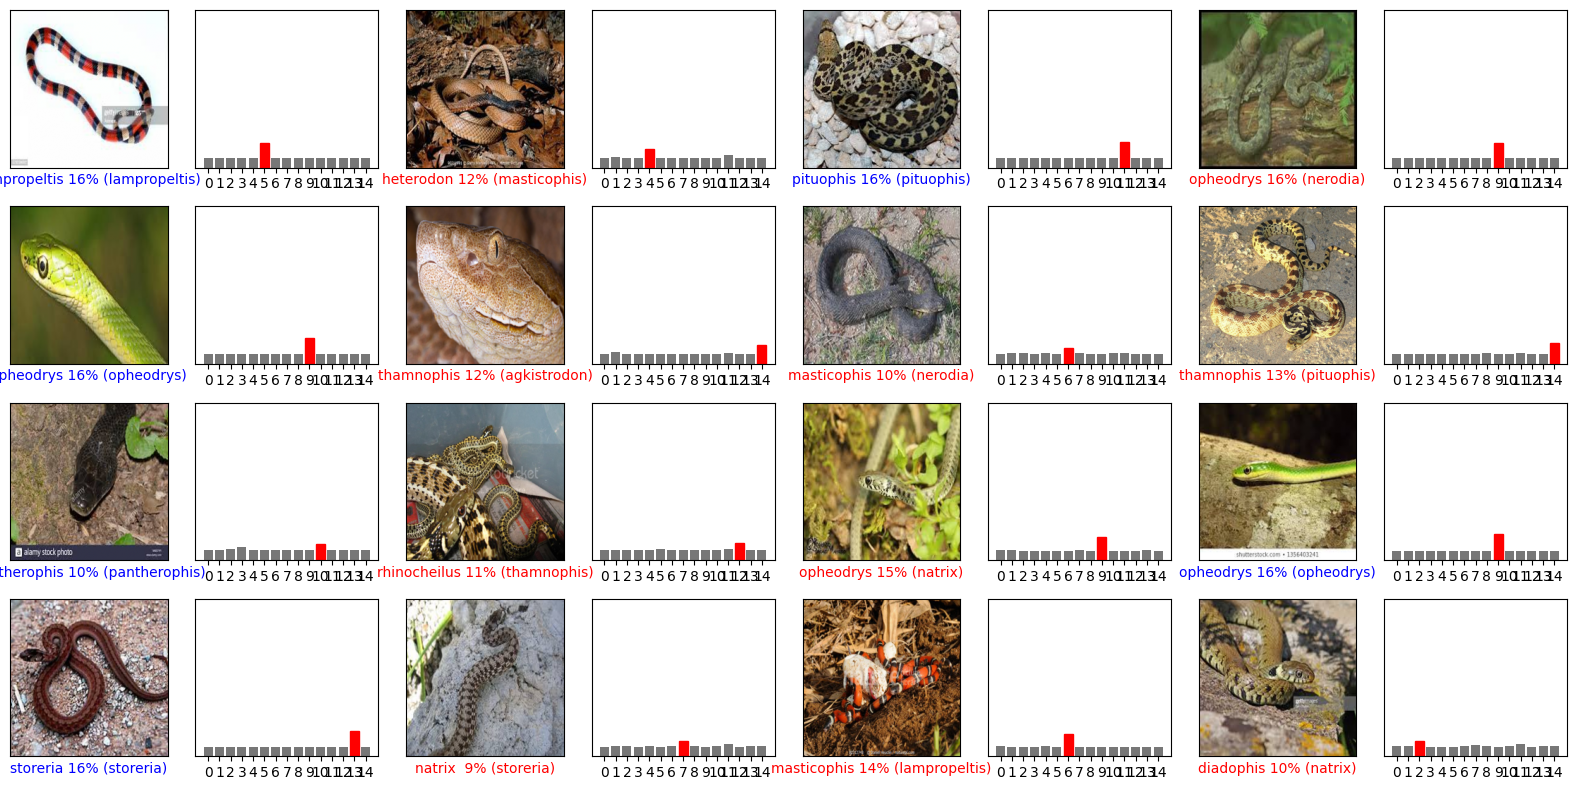

In [41]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)

  true_label_index = np.argmax(true_label)
  if predicted_label == true_label_index:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label_index]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(15))
  plt.yticks([])
  thisplot = plt.bar(range(15), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')

num_cols = 4
num_rows = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  # print(predictions[i])
  plot_image(i, predictions[i], Y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], Y_test)
plt.tight_layout()
plt.show()

## Appendix: Showing the model and accuracy from the other models:

In [ ]:
# 1.
model = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(15)
])

# Test Loss: 16.56937 // Test Accuracy: 22.33%

In [ ]:
# 2.
model = tf.keras.Sequential(
[
tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(15)
])

# Test Loss: 14.58765 // Test Accuracy: 24.54%

In [ ]:
# 3.
model = tf.keras.Sequential(
[
tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(15, activation =  'softmax')
])

# Test Loss: 3.68273 // Test Accuracy: 16.83%

In [ ]:
# 4.
model = tf.keras.Sequential(
[
tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(15, activation = 'softmax')
])

# Test Loss: 3.40557 // Test Accuracy: 16.83%

In [ ]:
# 6.
model = tf.keras.Sequential(
[
tf.keras.Input(shape= (224, 224, 3)),
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=""relu""),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=""relu""),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(15, activation=""softmax""),
]
)

# Test Loss: 11.71961 // Test Accuracy: 22.67%

In [ ]:
# 7.
model = tf.keras.Sequential(
[
tf.keras.Input(shape= (224, 224, 3)),
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=""relu""),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=""relu""),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=""relu""),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(15, activation=""softmax""),
]
)

# Test Loss: 9.59412 // Test Accuracy: 25.33%